In [1]:
import os
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from peft import PeftModel
from qwen_vl_utils import process_vision_info
from PIL import Image
import torch

/root/miniconda3/envs/qwenvl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# =============================
# 1. Load Base Model + LoRA Adapter
# =============================
BASE_MODEL = "Qwen/Qwen2.5-VL-7B-Instruct"
LORA_PATH = "/root/project/step1-vgjson-grounding-lora/checkpoint-4100"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True,
)

model = PeftModel.from_pretrained(base_model, LORA_PATH)
model.eval()

processor = AutoProcessor.from_pretrained(BASE_MODEL, use_fast=True, trust_remote_code=True)


Loading checkpoint shards: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


In [26]:

# =============================
# 2. Prepare Input
# =============================
IMG_PATH = "/root/project/data/visual_genome/VG_100K_2/1.jpg" 
prompt = "Describe this image."

image = Image.open(IMG_PATH).convert("RGB")

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": prompt},
        ],
    }
]


In [31]:

# =============================
# 3. Run Inference
# =============================
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)

inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    return_tensors="pt",
    padding=True,
).to(device)

generated_ids = model.generate(
    **inputs,
    max_new_tokens=1024,
    do_sample=False,
    temperature=0.7,
    top_k=50,
    top_p=0.95
)

generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]

output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=True
)


/root/miniconda3/envs/qwenvl/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/miniconda3/envs/qwenvl/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


In [32]:
# =============================
# 4. Output
# =============================
print(output_text[0])


let me explain all objects in the image.
[objects] man at (231, 145, 286, 297), woman at (140, 145, 182, 297), street at (190, 151, 332, 200), bicycle at (180, 182, 201, 204), tree at (280, 0, 332, 257), tree at (200, 0, 254, 200), tree at (254, 0, 300, 247), tree at (300, 0, 350, 247), tree at (349, 0, 400, 310), tree at (399, 0, 449, 310), tree at (349, 0, 400, 247), tree at (399, 0, 449, 310), tree at (254, 0, 300, 247), tree at (200, 0, 254, 200), tree at (280, 0, 332, 257), tree at (349, 0, 400, 247), tree at (399, 0, 449, 310), tree at (254, 0, 300, 247), tree at (200, 0, 254, 200), tree at (280, 0, 332, 257), tree at (349, 0, 400, 247), tree at (399, 0, 449, 310), tree at (254, 0, 300, 247), tree at (200, 0, 254, 200), tree at (280, 0, 332, 257), tree at (349, 0, 400, 247), tree at (399, 0, 449, 310), tree at (254, 0, 300, 247), tree at (200, 0, 254, 200), tree at (280, 0, 332, 257), tree at (349, 0, 400, 247), tree at (399, 0, 449, 310), tree at (254, 0, 300, 247), tree at (200

In [7]:
OUTPUT_TEXT = """let me explain all objects in the image.
    [objects] 
    green tall clock at (0.53, 0.15, 0.62, 0.72), 
    sidewalk street at (0.1, 0.55, 0.99, 0.98), 
    shade at (0.15, 0.56, 0.49, 0.88), 
    man at (0.3, 0.41, 0.37, 0.85), 
    grey sneakers at (0.3, 0.81, 0.37, 0.86), 
    off headlight at (0.64, 0.61, 0.67, 0.64), 
    car at (0.6, 0.53, 0.69, 0.69), parked far away bike 
    at (0.4, 0.53, 0.43, 0.59), parked far away chained bike at (0.42, 0.53, 0.45, 0.59),
    black sign at (0.15, 0.02, 0.26, 0.33), 
    tall brick made of bricks building at (0.0, 0.0, 0.27, 0.9), 
    tree trunk at (0.78, 0.39, 0.89, 0.94), 
    brick sidewalk at (0.1, 0.55, 1.0, 0.99), 
    red orange shirt at (0.3, 0.48, 0.38, 0.65), 
    clean street at (0.45, 0.47, 1.0, 0.86), 
    white parked car at (0.89, 0.57, 1.0, 0.86), 
    back at (0.9, 0.56, 0.98, 0.85), 
    glasses at (0.34, 0.45, 0.36, 0.47), 
    orange parking meter at (0.72, 0.55, 0.76, 0.78), 
    brown shoes at (0.49, 0.8, 0.55, 0.86), 
    man at (0.47, 0.44, 0.56, 0.86), 
    black pants at (0.31, 0.64, 0.35, 0.84), gray grey jacket at (0.45, 0.49, 0.56, 0.66), gray grey pants at (0.48, 0.61, 0.55, 0.83), sidewalk at (0.43, 0.53, 0.49, 0.84), raised chin at (0.5, 0.48, 0.51, 0.49), guy at (0.46, 0.44, 0.56, 0.86), parked white van at (0.66, 0.5, 0.95, 0.72), grey wall at (0.0, 0.0, 0.17, 0.89), tree at (0.31, 0.0, 0.53, 0.6), bikes at (0.4, 0.53, 0.45, 0.59), raised arm at (0.46, 0.47, 0.5, 0.54), grey shirt at (0.48, 0.51, 0.53, 0.62), man at (0.45, 0.44, 0.57, 0.85), man at (0.29, 0.42, 0.38, 0.86), road at (0.54, 0.49, 0.97, 0.85), lamp post at (0.67, 0.1, 0.72, 0.82), sparse trees at (0.24, 0.0, 0.99, 0.93), windows at (0.75, 0.01, 0.97, 0.25) [/objects]\n[reasoning]\n.\n[/reasoning]\nbased on objects, the answer is:\n[answer] .\n[/answer]"""

In [12]:
label

', windows'

✅ 감지된 객체 수: 39


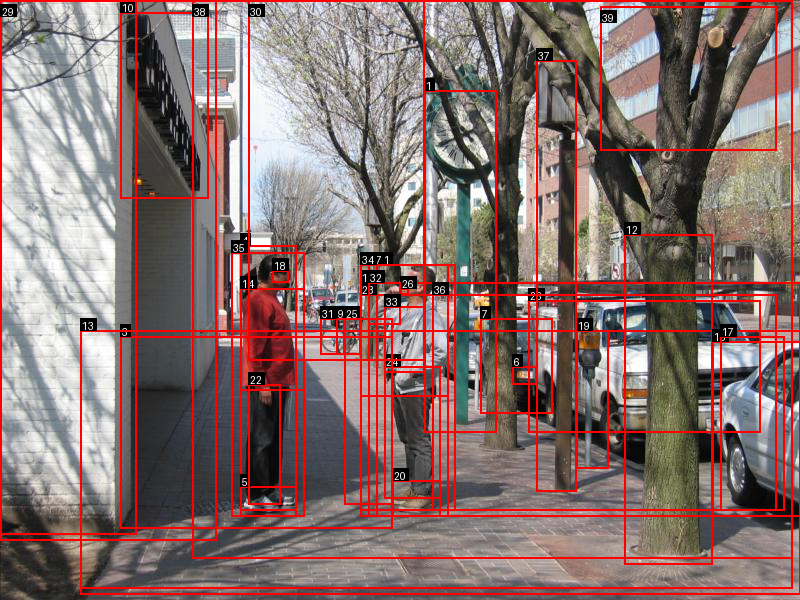


라벨 인덱스 목록:
  1: green tall clock
  2: sidewalk street
  3: shade
  4: man
  5: grey sneakers
  6: off headlight
  7: car
  8: parked far away bike
  9: parked far away chained bike
 10: black sign
 11: tall brick made of bricks building
 12: tree trunk
 13: brick sidewalk
 14: red orange shirt
 15: clean street
 16: white parked car
 17: back
 18: glasses
 19: orange parking meter
 20: brown shoes
 21: man
 22: black pants
 23: gray grey jacket
 24: gray grey pants
 25: sidewalk
 26: raised chin
 27: guy
 28: parked white van
 29: grey wall
 30: tree
 31: bikes
 32: raised arm
 33: grey shirt
 34: man
 35: man
 36: road
 37: lamp post
 38: sparse trees
 39: windows


In [29]:
import re
from PIL import Image, ImageDraw, ImageFont

# =============================
# 1. OUTPUT_TEXT 입력 (예시)
# =============================
# OUTPUT_TEXT = 

# =============================
# 2. 이미지 로드
# =============================
draw = ImageDraw.Draw(image)
W, H = image.size

try:
    font = ImageFont.truetype("arial.ttf", 12)
except:
    font = ImageFont.load_default()

# =============================
# 2. 객체 파싱
# =============================
object_section = re.search(r"\[objects\](.*?)\[/objects\]", OUTPUT_TEXT, re.DOTALL)
if not object_section:
    raise ValueError("No [objects] section found.")

object_text = object_section.group(1)

# 정규식으로 robust 추출
pattern = re.compile(r"(.*?) at\s*\(\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*\)", re.DOTALL)
objects = pattern.findall(object_text)

print(f"✅ 감지된 객체 수: {len(objects)}")

# =============================
# 3. 시각화: 번호만 표시
# =============================
label_map = {}  # 번호 → 라벨 매핑

for idx, (label, x1, y1, x2, y2) in enumerate(objects, start=1):
    label = label.strip()
    x1, y1, x2, y2 = float(x1), float(y1), float(x2), float(y2)
    box = [int(x1 * W), int(y1 * H), int(x2 * W), int(y2 * H)]

    draw.rectangle(box, outline="red", width=2)

    # 숫자 텍스트만 표시
    text = str(idx)
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_w = text_bbox[2] - text_bbox[0]
    text_h = text_bbox[3] - text_bbox[1]
    tx = box[0]
    ty = box[1] - text_h - 4
    if ty < 0:
        ty = box[1] + 4
    label = re.sub(r"^[,\s\n\t]+", "", label)  # 앞에 있는 쉼표, 공백, 개행, 탭 제거
    draw.rectangle([tx, ty, tx + text_w + 4, ty + text_h + 4], fill="black")
    draw.text((tx + 2, ty + 2), text, fill="white", font=font)

    label_map[idx] = label

# =============================
# 4. 결과 저장 및 라벨 출력
# =============================
image.save("vis_output.jpg")
image.show()

print("\n라벨 인덱스 목록:")
for idx, label in label_map.items():
    print(f"{idx:>3}: {label}")

In [17]:
label

', windows'